Нужно написать приложение, которое будет считывать и выводить кадры с
веб-камеры. В процессе считывания определять что перед камерой находится
человек, задетектировав его лицо на кадре. После этого, человек показывает жесты
руками, а алгоритм должен считать их и определенным образом реагировать на эти
жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами.
Например, на определенный жест (жест пис), система будет здороваться с человеком.
На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет для жестов рук.
Возможные датасеты:

● https://www.kaggle.com/gti-upm/leapgestrecog

● https://lttm.dei.unipd.it/downloads/gesture/

● https://www.kaggle.com/datamunge/sign-language-mnist

● https://www.kaggle.com/roobansappani/hand-gesture-recognition

Еще много интересной информации здесь.
На основании выбранного датасета нужно разработать модель для обучения и обучить
эту модель.
# Выбран датасет https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import os
import pandas as pd
import numpy as np
import string
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
import torch.optim as optim

import time
import seaborn
from facenet_pytorch import MTCNN
from sklearn.metrics import accuracy_score

In [2]:
#https://www.kaggle.com/datamunge/sign-language-mnist
train_df = pd.read_csv("./Signlang_mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("./Signlang_mnist/sign_mnist_test/sign_mnist_test.csv")

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


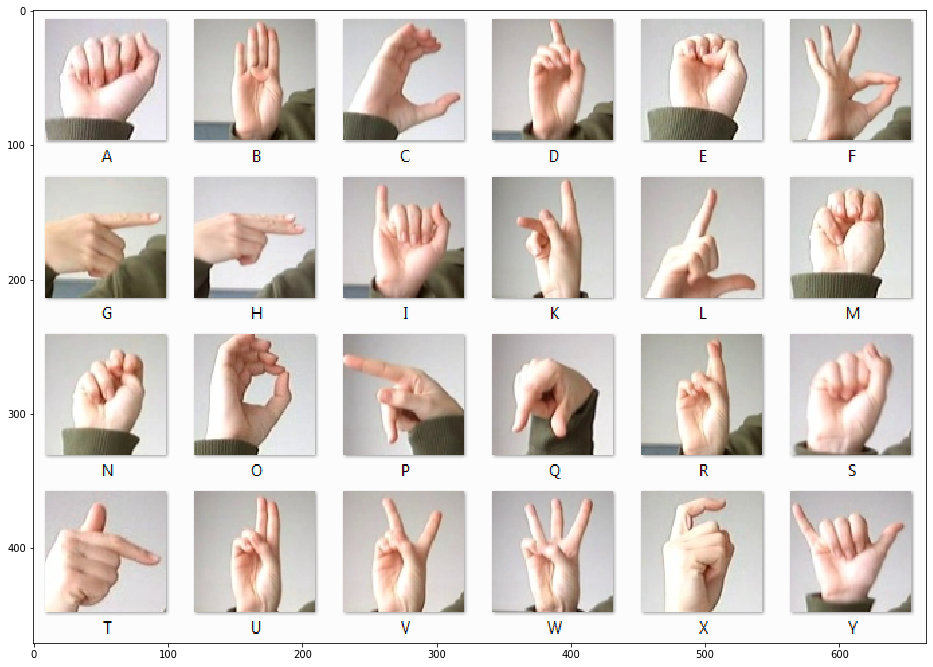

In [4]:
plt.figure(figsize = (16,16))
img = plt.imread('./Signlang_mnist/amer_sign2.png')
plt.imshow(img)
plt.show()

In [5]:
print('Number samples train:', len(train_df))
print('Number samples test:', len(test_df))

Number samples train: 27455
Number samples test: 7172


In [6]:
alphabet = {idx:letter for idx, letter in enumerate(string.ascii_lowercase)}
alphabet[1]

'b'

In [11]:
train_labels = train_df.label.apply(lambda x: alphabet[x])
test_labels = test_df.label.apply(lambda x: alphabet[x])
train_labels 

0        d
1        g
2        c
3        c
4        n
        ..
27450    n
27451    x
27452    s
27453    r
27454    x
Name: label, Length: 27455, dtype: object

In [12]:
class MnistSignDataset(Dataset):
   
    def __init__(self, img, label):
#         self.transforms = tt.ToTensor
        self.img = np.array(img/255.0)
        self.label = np.array(label)
            
    # Так же нужно переопределить метод __len__
    def __len__(self):
        return len(self.img)
    
    # И этот метод в который будет возвращать нам один сэмпл наших данных
    def __getitem__(self, idx):
        # преобразования над данными
        img = self.img[idx]
        img = torch.FloatTensor(img).reshape(1, 28, 28)
        label = self.label [idx]
        label = torch.tensor(label)
        return img, label


In [13]:
batch_size = 128

In [14]:
train_dataset = MnistSignDataset(train_df.drop('label', axis=1), train_df.label)
train_dataloader = DataLoader(train_dataset, batch_size)

In [15]:
train_dataset[111]

(tensor([[[0.3176, 0.4157, 0.2706, 0.1020, 0.2667, 0.3059, 0.3216, 0.3412,
           0.3569, 0.4078, 0.4549, 0.4745, 0.5020, 0.5137, 0.5255, 0.5412,
           0.5451, 0.5569, 0.5686, 0.5804, 0.5843, 0.5882, 0.5961, 0.6000,
           0.6078, 0.6157, 0.6196, 0.6235],
          [0.3608, 0.4196, 0.2314, 0.1176, 0.2824, 0.3059, 0.3255, 0.3451,
           0.3647, 0.4157, 0.4627, 0.4824, 0.5059, 0.5216, 0.5373, 0.5451,
           0.5569, 0.5569, 0.5725, 0.5686, 0.5882, 0.5961, 0.6000, 0.6118,
           0.6118, 0.6196, 0.6235, 0.6314],
          [0.3843, 0.4235, 0.1961, 0.1333, 0.2902, 0.3098, 0.3294, 0.3490,
           0.3725, 0.4235, 0.4667, 0.4902, 0.5137, 0.5216, 0.5373, 0.5490,
           0.5569, 0.5647, 0.6431, 0.4627, 0.5412, 0.6157, 0.6039, 0.6118,
           0.6196, 0.6275, 0.6314, 0.6353],
          [0.3961, 0.4157, 0.1647, 0.1608, 0.2980, 0.3098, 0.3333, 0.3529,
           0.3765, 0.4314, 0.4706, 0.4941, 0.5137, 0.5255, 0.5412, 0.5490,
           0.5490, 0.5882, 0.6824, 0.4588, 

In [18]:
test_dataset = customDataset(test_df.drop('label', axis=1), test_df.label)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [19]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(np.squeeze(make_grid(images, nrow=16).permute(1, 2, 0)))
        break

torch.Size([1, 28, 28])


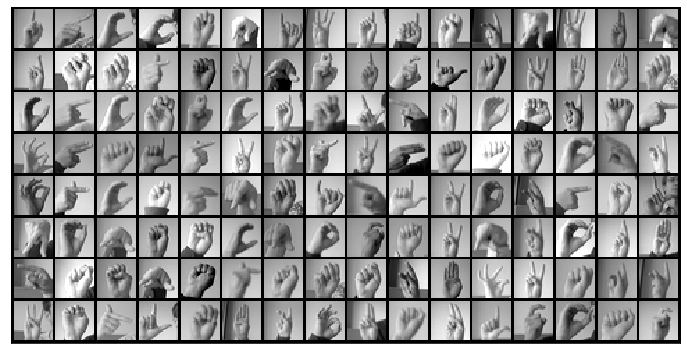

In [20]:
showbatch(train_dataloader)

In [23]:
#Функции для перевода моделей и даталоадеров на необходимое оборудование:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cpu')

In [25]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

### Модель

In [26]:
class Mnist_Gesture(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 1*28*28
        self.conv1 = self.conv_block(in_channels, 16, pool=True)
        self.drop1 = nn.Dropout(0.2)
        # 16*14*14
        self.conv2 = self.conv_block(16, 32, pool=True)
        self.drop2 = nn.Dropout(0.2)
        # 32*7*7
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.drop3 = nn.Dropout(0.2)
        
                
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(64*3*3, 64),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.2),
                                        nn.Linear(64, num_classes))
        
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.drop3(out)
#         print(out.size())
        
        out = self.classifier(out)
        return out

In [27]:
model = to_device(Mnist_Gesture(1, len(alphabet)), device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
              ReLU-8           [-1, 32, 14, 14]               0
         MaxPool2d-9             [-1, 32, 7, 7]               0
          Dropout-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
      BatchNorm2d-12             [-1, 64, 7, 7]             128
             ReLU-13             [-1, 64, 7, 7]               0
        MaxPool2d-14             [-1, 6

In [28]:
def accuracy(pred, true):
    pred = np.argmax(pred.to('cpu').detach().numpy(), axis=1)
    true = true.to('cpu').detach().numpy()
    return len(np.where(pred==true)[0])/len(true)

def showCategory(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return labels[category_i], category_i

In [29]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


In [33]:
epochs = 3
learning_rate = 0.001
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

3 epochs, 215 total_steps per epoch


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
train_loss_history = []
accuracy_history = []
counter = 0
start = time.time()
for epoch in range(epochs):
    epoch_accuracy = []
    epoch_loss = []
    for i, data in enumerate(train_dataloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy(outputs, labels))
        category = labels[int(labels[0])]
        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(outputs)
            correct = '✓' if guess == category else '✗ (%s)' % category
        counter = counter + 1
    
    train_loss_history.append(np.mean(epoch_loss))
    accuracy_history.append(np.mean(epoch_accuracy))
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}, accuracy: {np.mean(epoch_accuracy)} / {guess} {correct}')

In [38]:
train_loss_history = []
accuracy_history = []
counter = 0
start = time.time()
for epoch in range(epochs):
    epoch_accuracy = []
    #epoch_loss = []
    #for i, data in enumerate(train_dataloader, 0):
    with tqdm(train_dataloader, unit="batch") as progress:
        
        epoch_accuracy = []
        epoch_loss = []
        sum_correct = 0
        for data, labels in progress:
            progress.set_description(f"Epoch {epoch + 1}")
        
            data, labels = data.to(device), labels.to(device)
            out = model(data) #outputs = model(inputs)
            loss = criterion(out, labels.squeeze()) #loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            #epoch_loss += loss.item()
            epoch_loss.append(loss.item())
            epoch_accuracy.append(accuracy(out, labels))
            
            category = labels[int(labels[0])]
            guess, guess_i = showCategory(out)
            correct = '✓' if guess == category else '✗ (%s)' % category
            sum_correct += 1 if correct == '✓' else 0
            
            progress.set_postfix(loss = loss.item(), accuracy = (np.mean(epoch_accuracy))) # show loss and per batch of data
        
           
        
        


Epoch 1: 100%|█| 215/215 [00:32<00:00,  6.64batch/s, accuracy=0.516, loss=0.864
Epoch 2: 100%|█| 215/215 [00:44<00:00,  4.84batch/s, accuracy=0.869, loss=0.314
Epoch 3: 100%|█| 215/215 [00:35<00:00,  6.02batch/s, accuracy=0.936, loss=0.205


In [40]:
torch.save(model.state_dict(), 'gesture_detection.pth')

### Test

In [ ]:
#model.load_state_dict(torch.load('gesture_detection.pth'))

torch.Size([1, 1, 28, 28])
torch.Size([26])
g


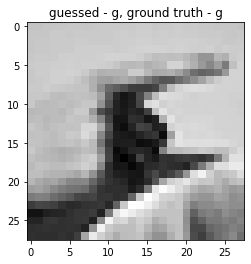

torch.Size([1, 1, 28, 28])
torch.Size([26])
f


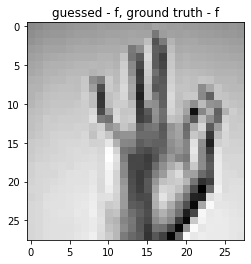

torch.Size([1, 1, 28, 28])
torch.Size([26])
k


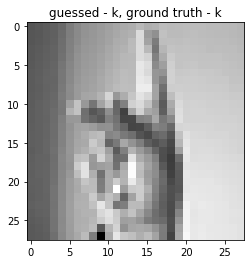

torch.Size([1, 1, 28, 28])
torch.Size([26])
a


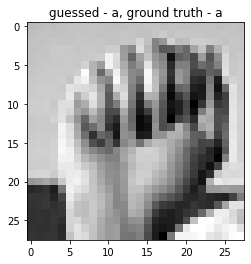

torch.Size([1, 1, 28, 28])
torch.Size([26])
d


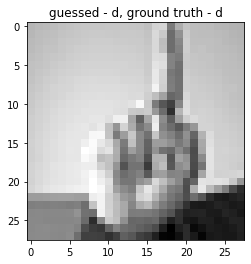

torch.Size([1, 1, 28, 28])
torch.Size([26])
v


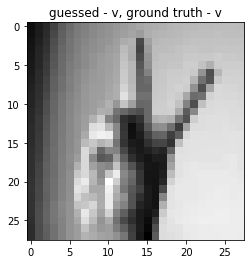

torch.Size([1, 1, 28, 28])
torch.Size([26])
k


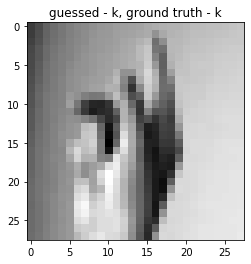

torch.Size([1, 1, 28, 28])
torch.Size([26])
o


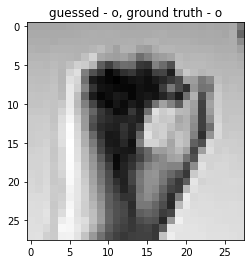

torch.Size([1, 1, 28, 28])
torch.Size([26])
k


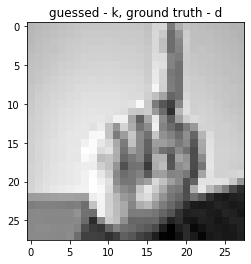

torch.Size([1, 1, 28, 28])
torch.Size([26])
t


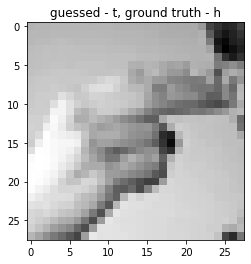

torch.Size([1, 1, 28, 28])
torch.Size([26])
i


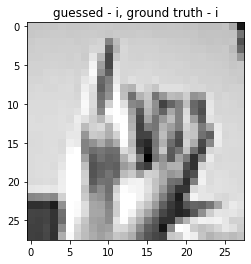

torch.Size([1, 1, 28, 28])
torch.Size([26])
i


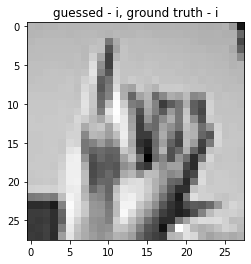

In [43]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        out= model(images)
        print(alphabet[out[0].argmax().item()])
        
        plt.title(f'guessed - {alphabet[out[0].argmax().item()]}, ground truth - {alphabet[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

Проверяем точность прогнозов

Text(0.5, 69.0, 'Predicted label')

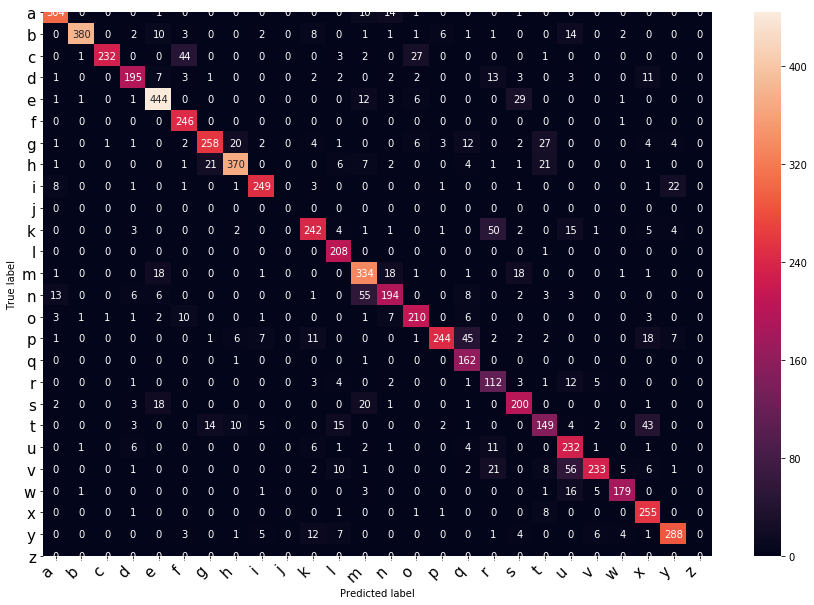

In [46]:
confusion_matrix = torch.zeros(len(alphabet), len(alphabet))

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        out = model(inputs)
        _, preds = torch.max(out, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(alphabet.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### real Web-cam test

In [49]:
img28 = cv2.resize('kin_rgb.png',(28,28))
img28 = cv2.cvtColor(img28, cv2.COLOR_BGR2RGB)
# Превращаем в 1-канальное серое изображение
img28 = cv2.cvtColor(img28, cv2.COLOR_BGR2GRAY)
img28 = Image.fromarray(img28)
#face = face.resize((48,48))
img28 = np.asarray(img28).astype('float')
img28 = torch.as_tensor(img28)

img28.shape



TypeError: Expected Ptr<cv::UMat> for argument 'src'